## USING LONG AND SHORT TECHNIQUE

In [15]:
!pip install backtrader

In [16]:
import backtrader as bt
import datetime
import matplotlib.pyplot as plt


In [17]:
cerebro=bt.Cerebro()
cerebro.broker.set_cash(1000)
datapath="ITC.NS.csv"

data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    fromdate=datetime.datetime(2000, 1, 1),
    todate=datetime.datetime(2000, 12, 31),
    reverse=False)
cerebro.adddata(data)

# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.order=None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        if self.order:
          return;
        if not self.position:
          # if we are not in position, we're gonna buy
          print(len(self))
          print(self.order)
          print(self.position)
          if self.dataclose[0]<self.dataclose[-1] and self.dataclose[-1]<self.dataclose[-2]:
            self.log("BUY CREATE,%.2f" %self.dataclose[0])
            self.order=self.buy()
        else:
          if len(self)>self.bar_executed+5:
            self.log("BUY CREATE,%.2f" %self.dataclose[0])
            self.order=self.buy()
      
    def notify_order(self,order):
      if order.status in [order.Submitted, order.Accepted]:
        return
      if order.status in [order.completed]:
        if order.isbuy():
          self.log("BUY EXECUTED,%.2f" %order.executed.price)

        if order.issell():
          self.log("SELL EXECUTED,%.2f" %order.executed.price)

      self.bar_executed=len(self)
      self.order=None

    # if we are in position, we are gonna sell
cerebro.addstrategy(TestStrategy)        
cerebro.addsizer(bt.sizers.FixedSize,stake=100)
start=cerebro.broker.getvalue()
cerebro.run()
end=cerebro.broker.getvalue()
print("start is",start,"and end is",end)

2000-01-03, Close, 9.96
1
None
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
2000-01-04, Close, 10.02
2
None
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
2000-01-05, Close, 10.21
3
None
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
2000-01-06, Close, 11.03
4
None
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
2000-01-07, Close, 11.91
5
None
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
2000-01-10, Close, 12.87
6
None
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
2000-01-11, Close, 12.43
7
None
--- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- O

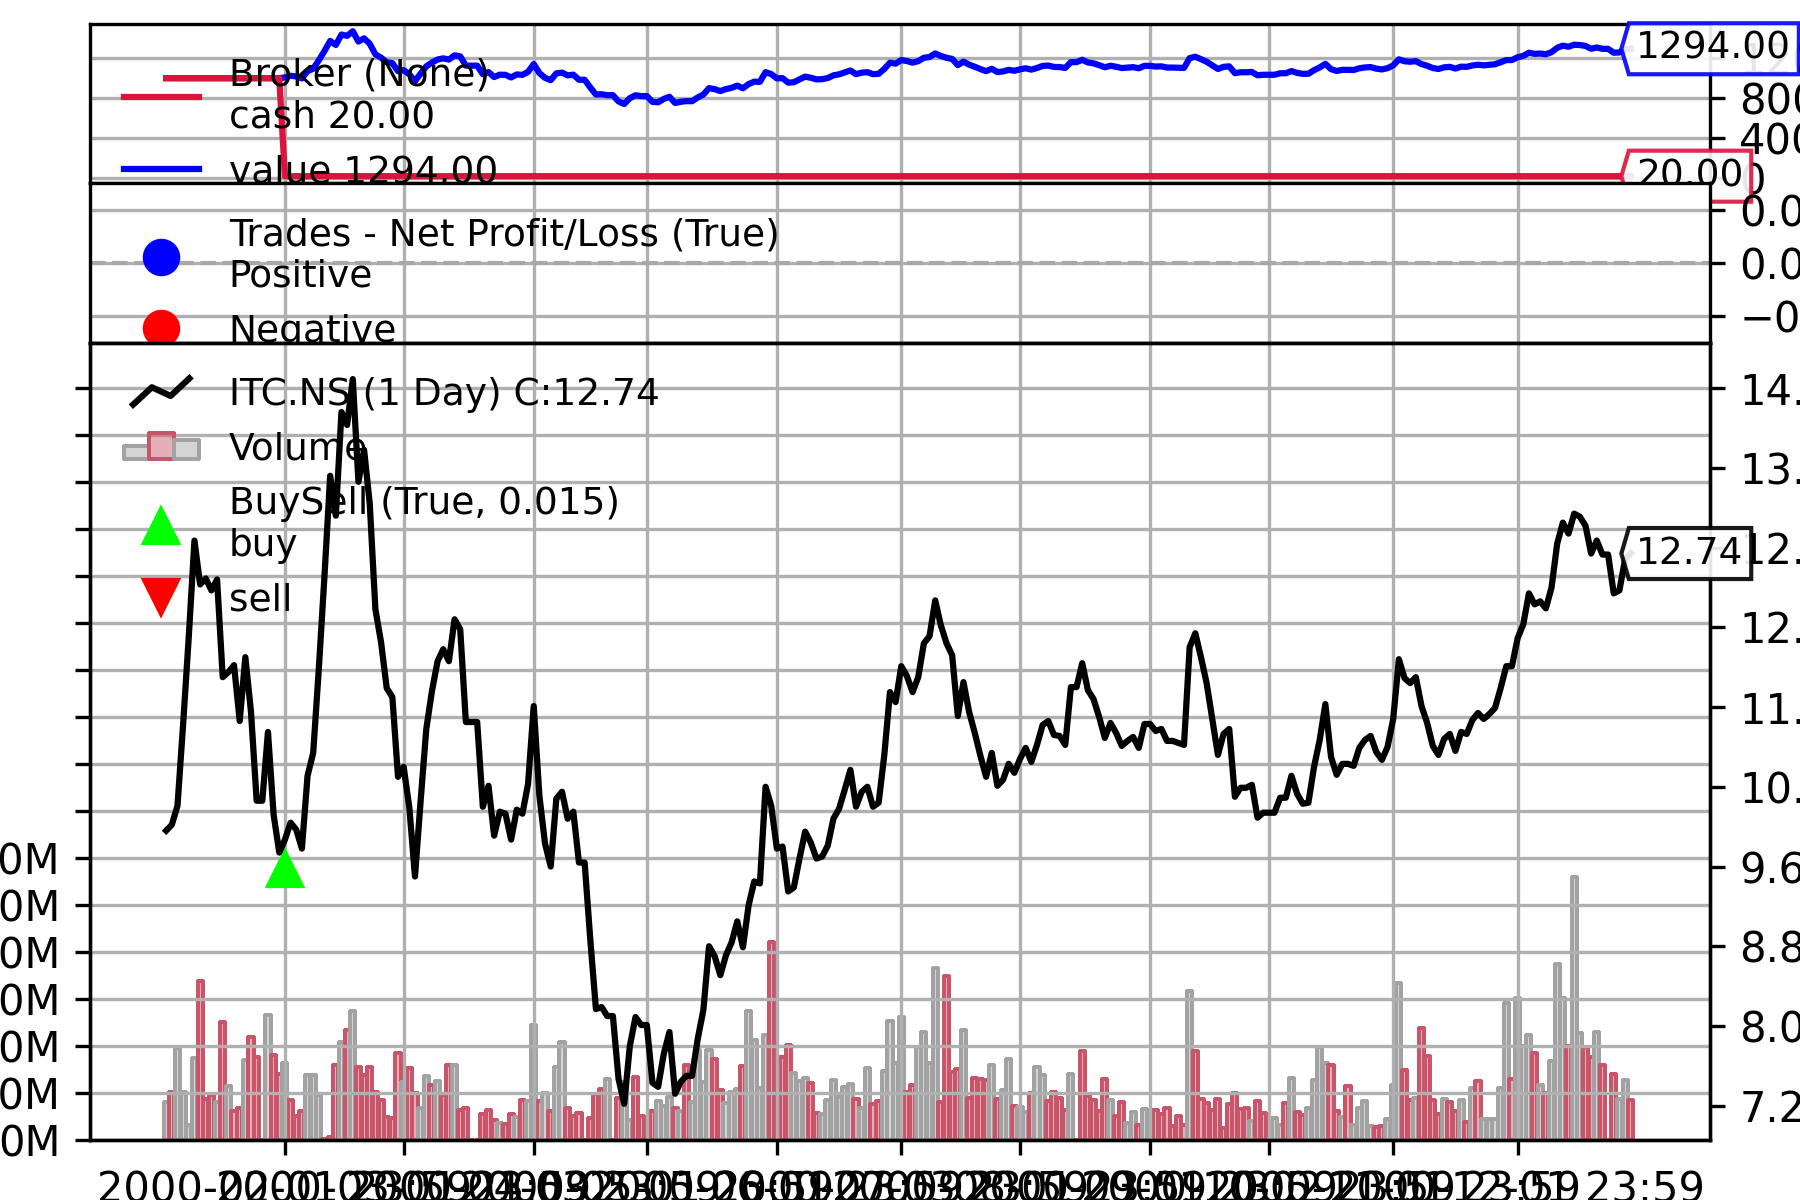

In [18]:
cerebro.plot()
plt.show()
from google.colab import files
from IPython.display import Image
chart_file = 'SIMPLE_BUY_SELL.png'
cerebro.plot()[0][0].savefig(chart_file, dpi=300)
Image(open(chart_file, 'rb').read())

## GOLDENCROSS ALGO - MULTIPLE INDICATORS

In [19]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        self.log('Close, %.2f' % self.dataclose[0])

        if self.order:
            return

        if not self.position:

            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            if len(self) >= (self.bar_executed + 5):
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)
    datapath="ITC.NS.csv"
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        fromdate=datetime.datetime(2000, 1, 1),
        todate=datetime.datetime(2000, 12, 31),
        reverse=False)

    cerebro.adddata(data)
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.001)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2000-01-03, Close, 9.96
2000-01-04, Close, 10.02
2000-01-05, Close, 10.21
2000-01-06, Close, 11.03
2000-01-07, Close, 11.91
2000-01-10, Close, 12.87
2000-01-11, Close, 12.43
2000-01-12, Close, 12.49
2000-01-13, Close, 12.37
2000-01-14, Close, 12.48
2000-01-17, Close, 11.50
2000-01-18, Close, 11.55
2000-01-19, Close, 11.62
2000-01-20, Close, 11.06
2000-01-21, Close, 11.70
2000-01-24, Close, 11.15
2000-01-25, Close, 10.26
2000-01-25, BUY CREATE, 10.26
2000-01-26, BUY EXECUTED, Price: 10.26, Cost: 10.26, Comm 0.01
2000-01-26, Close, 10.26
2000-01-27, Close, 10.95
2000-01-28, Close, 10.12
2000-01-31, Close, 9.74
2000-02-01, Close, 9.87
2000-02-02, Close, 10.04
2000-02-02, SELL CREATE, 10.04
2000-02-03, SELL EXECUTED, Price: 10.14, Cost: 10.26, Comm 0.01
2000-02-03, OPERATION PROFIT, GROSS -0.12, NET -0.14
2000-02-03, Close, 9.97
2000-02-04, Close, 9.78
2000-02-04, BUY CREATE, 9.78
2000-02-07, BUY EXECUTED, Price: 9.96, Cost: 9.96, Comm 0.01
2000-02-07, C

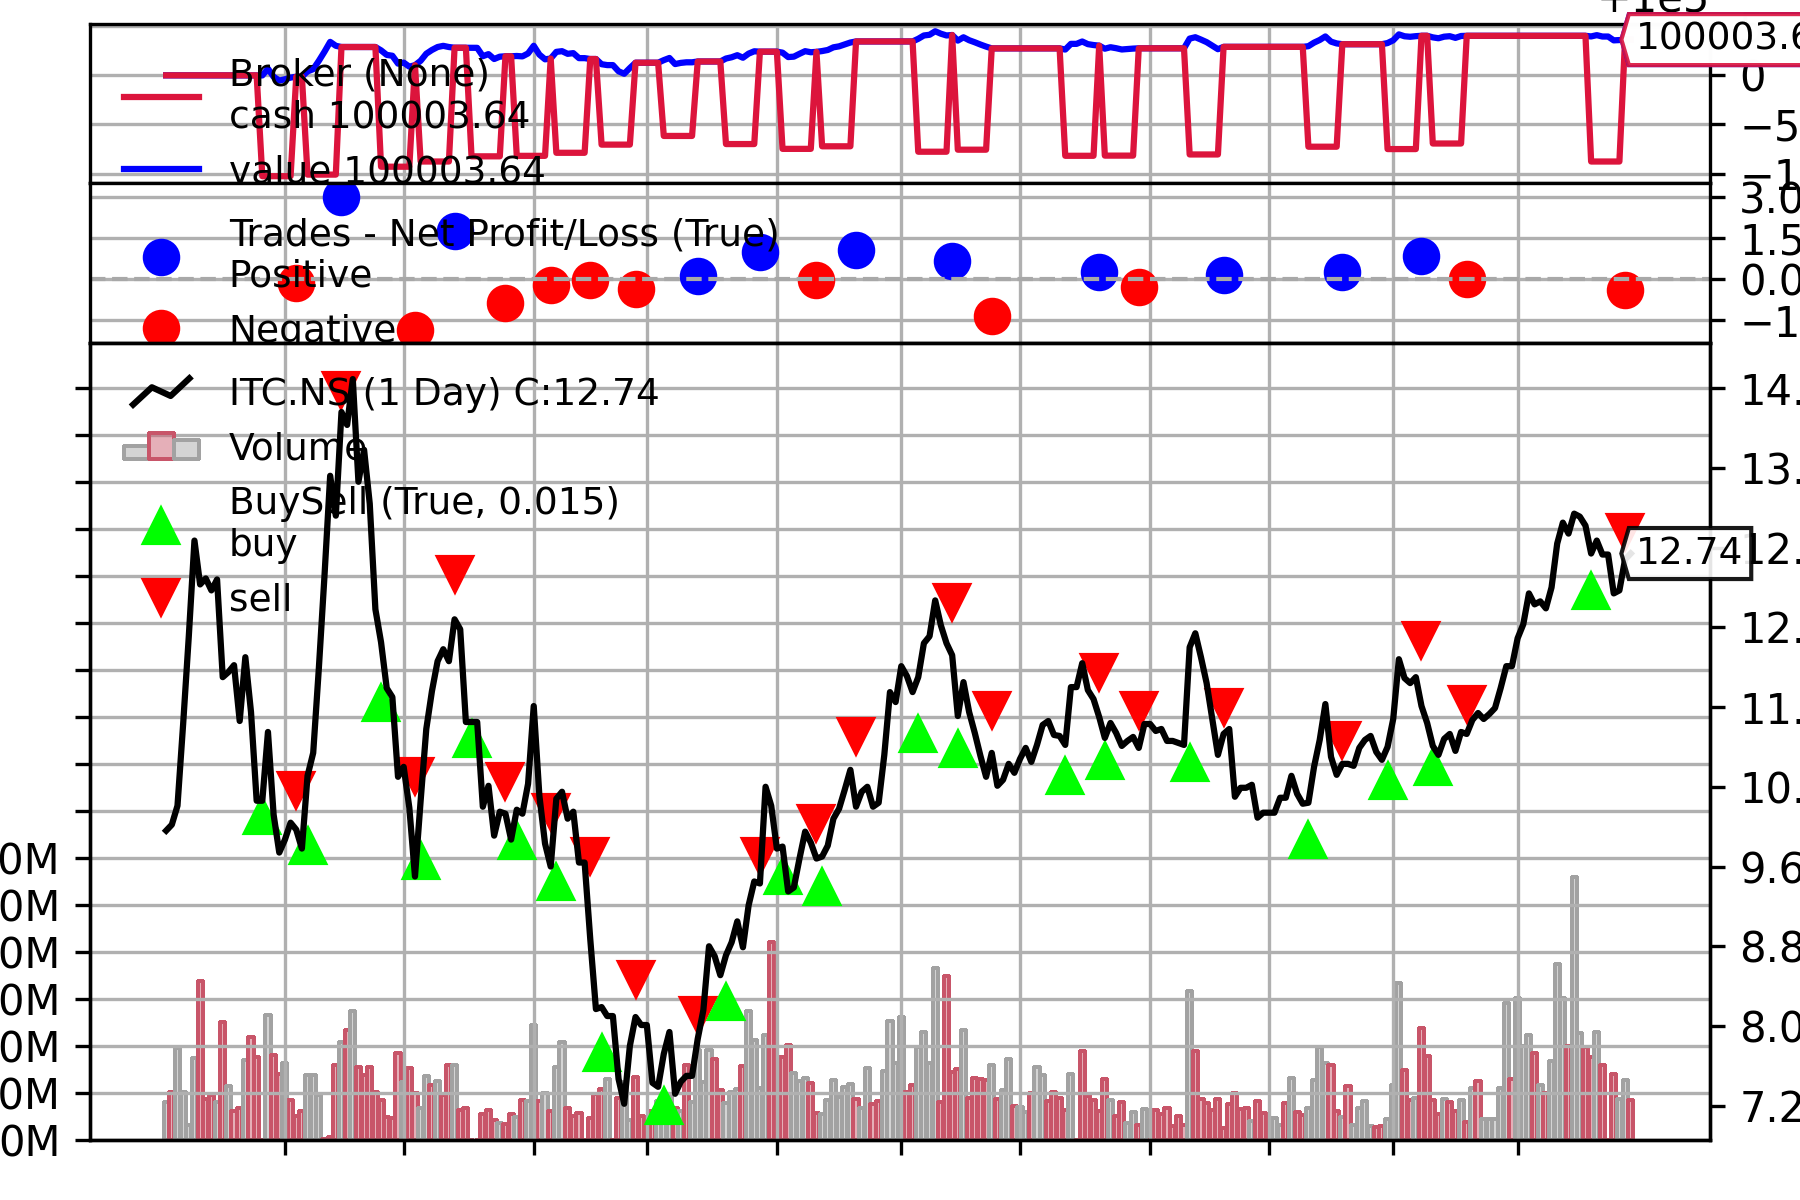

In [20]:
cerebro.plot()
plt.show()
from google.colab import files
from IPython.display import Image
chart_file = 'GOLDEN_CROSS.png'
cerebro.plot()[0][0].savefig(chart_file, dpi=300)
Image(open(chart_file, 'rb').read())

# Average Directional Movement Index


In [68]:
ADX = 25
QTY = 1


class ADXDMICross(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.adx = bt.ind.ADX()
        self.dmiplus, self.dmimin = bt.ind.PlusDI(), bt.ind.MinusDI()
        self.crossoverdmi = bt.ind.CrossOver(self.dmimin, self.dmiplus)

    def next(self):
        if self.dmiplus > self.dmimin and self.adx[0] > ADX:
            self.buy(size=QTY)

        if self.dmiplus < self.dmimin and self.adx[0] > ADX:
            self.close(size=QTY)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))


cerebro = bt.Cerebro(stdstats=False)
cerebro.addobserver(bt.observers.BuySell)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Starting Portfolio Cash: %.2f' % cerebro.broker.get_cash())
cerebro.addstrategy(ADXDMICross)
cerebro.broker.setcommission(commission=0.001)
datapath = "ITC.NS.csv"
data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    fromdate=datetime.datetime(2000, 1, 1),
    todate=datetime.datetime(2000, 12, 31),
    reverse=False)
cerebro.adddata(data)
cerebro.broker.set_cash(100000.0)
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Final Portfolio Cash: %.2f' % cerebro.broker.get_cash())
figure = plt.gcf()
figure.set_size_inches(10,5)
cerebro.plot()[0][0].savefig('ADMI.png', dpi=300)

Starting Portfolio Value: 10000.00
Starting Portfolio Cash: 10000.00
2000-02-11, BUY EXECUTED, Price: 13.52, Cost: 13.52, Comm 0.01
2000-02-14, BUY EXECUTED, Price: 14.04, Cost: 14.04, Comm 0.01
2000-02-15, BUY EXECUTED, Price: 13.01, Cost: 13.01, Comm 0.01
2000-02-16, BUY EXECUTED, Price: 14.48, Cost: 14.48, Comm 0.01
2000-02-17, BUY EXECUTED, Price: 14.05, Cost: 14.05, Comm 0.01
2000-02-18, BUY EXECUTED, Price: 14.56, Cost: 14.56, Comm 0.01
2000-02-21, BUY EXECUTED, Price: 13.92, Cost: 13.92, Comm 0.01
2000-02-22, BUY EXECUTED, Price: 13.85, Cost: 13.85, Comm 0.01
2000-02-23, BUY EXECUTED, Price: 13.38, Cost: 13.38, Comm 0.01
2000-02-24, BUY EXECUTED, Price: 12.18, Cost: 12.18, Comm 0.01
2000-02-25, BUY EXECUTED, Price: 12.22, Cost: 12.22, Comm 0.01
2000-02-28, BUY EXECUTED, Price: 11.53, Cost: 11.53, Comm 0.01
2000-02-29, BUY EXECUTED, Price: 11.39, Cost: 11.39, Comm 0.01
2000-03-01, SELL EXECUTED, Price: 10.41, Cost: 13.24, Comm 0.01
2000-03-02, SELL EXECUTED, Price: 10.70, Cost: 1